# Convolutional Neural Network (CNN)
- recognize the digit using pixel value
- use PyTorch

## Import the libraries

In [225]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [87]:
# use cuda to accelerate the computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Import datasets

In [88]:
df_train = pd.DataFrame(pd.read_csv('train.csv'))
df_test = pd.DataFrame(pd.read_csv('test.csv'))

In [89]:
df_train.head(1)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Understand and visualize the dataset

### The unique digit in the dataset

In [90]:
unique_values = df_train['label'].unique()
unique_values.sort()
print(unique_values)

[0 1 2 3 4 5 6 7 8 9]


### The distribution of the label in the dataset
- the distribution is roughly uniform

In [91]:
df_train.plot.hist(by='label')

In [92]:
df_train.value_counts('label')

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
dtype: int64

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [146]:
y = df_train['label']
X = df_train.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Use MinMaxScaler to normalize data
- the digit label doesn't need to be normalized since it's the target class
- normalize the pixel values

In [147]:
scaler = MinMaxScaler()
# reference: https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe
# the fit_transform method always used on training data
# the purpose is to calculate the mean and variance of each of the features
X_train = scaler.fit_transform(X_train)
# the transform method uses the calculated mean and variance
# to transform the test data

# the label doesn't need to be normalized -> it's the digit class
X_test = scaler.fit_transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [148]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((28140, 784), (13860, 784), (28140,), (13860,))

## Following the tutorial
reference: https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

In [175]:
class ClassifierDataset(Dataset):
  def __init__(self, X_data, y_data):
    super(ClassifierDataset, self).__init__()
    self.X_data = X_data
    self.y_data = y_data
      
  def __getitem__(self, index):
    return self.X_data[index], self.y_data[index]
      
  def __len__ (self):
    return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

## Define and optimize the model
- specify the parameters
- specify optimization model and learning rate

In [212]:
# TODO: tune the parameters
EPOCHS = 10
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 10

In [213]:
# training loader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
train_loader

In [214]:
# validation loader
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

### Simple 3-layer feed-forward network
- with drop and batch-norm

In [215]:
class MulticlassClassification(nn.Module):
    """ The simple three layer multi-classification class
    
    """
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [216]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

MulticlassClassification(
  (layer_1): Linear(in_features=784, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

### Specify the optimizer

In [217]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### The model description

In [218]:
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=784, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Training the model

In [219]:
def multi_acc(y_pred, y_test):
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
  
  correct_pred = (y_pred_tags == y_test).float()
  acc = correct_pred.sum() / len(correct_pred)
  
  acc = torch.round(acc * 100)
  
  return acc

In [220]:
accuracy_stats = {
  'train': [],
  "val": []
}
loss_stats = {
  'train': [],
  "val": []
}

In [221]:
# reference: https://stackoverflow.com/questions/54374935/how-to-fix-this-strange-error-runtimeerror-cuda-error-out-of-memory
import gc
gc.collect()

torch.cuda.empty_cache()

In [222]:
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))

    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.45411 | Val Loss: 0.15239 | Train Acc: 88.014| Val Acc: 95.512
Epoch 002: | Train Loss: 0.21259 | Val Loss: 0.11883 | Train Acc: 93.935| Val Acc: 96.349
Epoch 003: | Train Loss: 0.14583 | Val Loss: 0.10230 | Train Acc: 95.882| Val Acc: 96.760
Epoch 004: | Train Loss: 0.11269 | Val Loss: 0.10097 | Train Acc: 96.758| Val Acc: 96.948
Epoch 005: | Train Loss: 0.08747 | Val Loss: 0.09450 | Train Acc: 97.390| Val Acc: 97.150
Epoch 006: | Train Loss: 0.06910 | Val Loss: 0.09455 | Train Acc: 97.916| Val Acc: 97.013
Epoch 007: | Train Loss: 0.05316 | Val Loss: 0.09644 | Train Acc: 98.377| Val Acc: 97.323
Epoch 008: | Train Loss: 0.04649 | Val Loss: 0.09487 | Train Acc: 98.576| Val Acc: 97.359
Epoch 009: | Train Loss: 0.04114 | Val Loss: 0.10993 | Train Acc: 98.720| Val Acc: 97.186
Epoch 010: | Train Loss: 0.03560 | Val Loss: 0.10021 | Train Acc: 98.905| Val Acc: 97.374


Text(0.5, 1.0, 'Train-Validation Loss/Epoch')

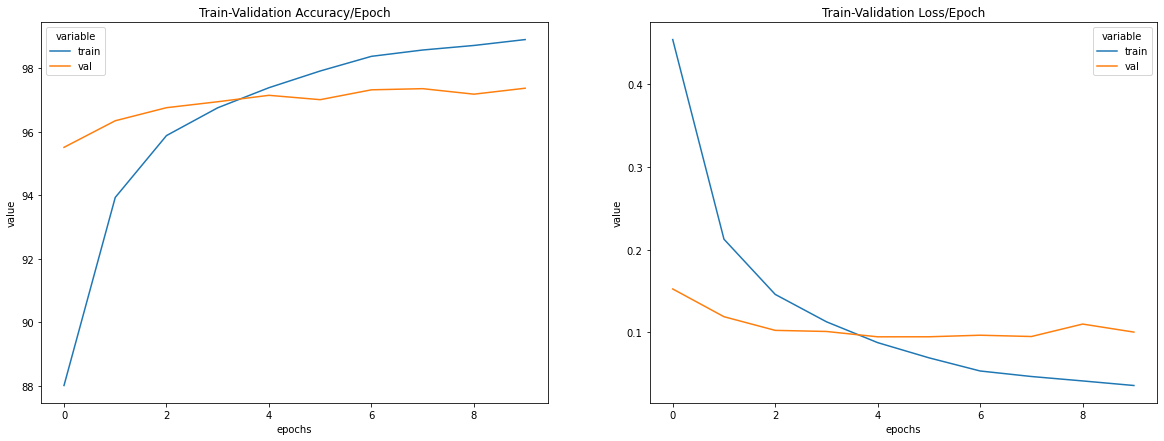

In [227]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Validation Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Validation Loss/Epoch')